# Probabilistic Machine Learning
#### Machine Learning in Science, University of Tübingen, Summer Semester 2022
## Exercise 05

**hand in before 27.05.2022, 12:00 p.m. (noon)**

---

## Julian Zimmerlin 6009977
## Leander Zimmermann 4165446



# EXAMple

# Theory

## a)
\begin{align*}
    p(y\mid r) &= \frac{(r \Delta t)^y \exp(-r \Delta t)}{y!} \\    
    p(y_{1:T, 1:L}\mid r) &= \prod_{t,l}^{T,L}p(y_{t,l}\mid r)\\
    &= \prod_{t,l}^{T,L} \frac{(r \Delta t)^{y_{t,l}} \exp(-r \Delta t)}{y_{t,l}!} 
    \\
    \log p(y_{1:T, 1:L}\mid r) 
    &= \sum_{t,l}^{T,L} \log (r \Delta t)^{y_{t,l}} -r \Delta t - \log y_{t,l}! \\
    &= \sum_{t,l}^{T,L} y_{t,l} \log(r \Delta t)-r \Delta t - \sum_{i=1}^{y_{t,l}}\log i
    \\
    \frac{\partial \log p(y_{1:T, 1:L}\mid r)}{\partial r}
    &= \sum_{t,l}^{T,L} \frac{y_{t,l}\Delta t}{r \Delta t} - \Delta t \\
    &= - TL \Delta t + \frac{1}{r}\sum_{t,l}^{T,L}  y_{t,l} \overset{!}{=} 0  \\
    r &= \frac{1}{TL \Delta t}\sum_{t,l}^{T,L}  y_{t,l}
\end{align*}


---

In the theory exercise this week, you explored the use of Poisson Generalized Linear Models in the context of spike trains in neuronal activity. Here, you will implement and evaluate these results in practice.

## Outline
1) Implement the Poisson GLM for the neuronal activity setting, and simulate data from it.
2) Estimate the neuron's receptive field (the filter $\boldsymbol{\omega}$) 
    - using the spike trains only
    - using an MLE for $\boldsymbol{\omega}$
    - using a Laplace approximation to the posterior over $\boldsymbol{\omega}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.special import factorial,gammaln


## 

### 1) Implement the model and generate ground-truth data.

Recall the model of the spike events in the neurons from the theory exercise:

\begin{align*}
	z_t &= \sum_{k=1}^K \omega_k x_{t-k} + b \\ 
	r_t &= \exp(z_t) \\ 
	y_t &= \text{Poisson}(r_t \Delta t).
\end{align*}

As a first step you want to generate spike counts from this model that we treat as our "observed" data below. To this end, you need a stimulus $\boldsymbol{x}$, and the underlying filter $\boldsymbol{\omega}$. 
Note that in a real world setting this would not be given: the filter is a property of the neuron that we want to discover, it determines what kind of stimulus it response to and how. 

To generate a "ground-truth" filter we provided `make_filter` function below.

In [2]:
def make_filter(lags, mu1=3., mu2=8., s1=1., s2=5., eta=.2):
    """Returns a filter constructed by a mixture of 2 Gaussians (N(range(lags) | mu1, s1) - eta * N(range(lags) | mu2, s2)).
    Parameters:
    lags : int. value. Length of filter to be constructed.
    mu1 : float value. Mean of first Gaussian.
    mu2 : float value. Mean of second Gaussian.
    s1 : float value. Std of first Gaussian.
    s2 : float value. Std of second Gaussian.
    eta : float value. Weight parameter for second Gaussian
    
    Returns:
    _filter : vector of float values of size 'lags'.
    """
    x = np.arange(lags)
    gauss1 = np.exp(- (x - mu1) ** 2 / (2 * s1**2))
    gauss2 = eta * np.exp(- (x - mu2) ** 2 / (2 * s2**2))
    _filter = gauss1 -  gauss2;
    _filter = _filter / np.linalg.norm(_filter)
    return _filter


(a) Along with the fixed parameters given below, generate a convolution filter $\boldsymbol{\omega}$. 

(b) Use the given stimulus to generate a firing rate and the corresponding spike trains for each trial, $\mathbf{y_l}, \; l=1, \ldots, L$. This will be our ground truth dataset. (Hint: given the parameters below you should obtain a binary matrix of shape `(200, 100)` where row is a trial, and each column a time step.)

(c) Plot the generated spike trains and the firing rate next below each other in two subplots. Make sure to add titles and axis labels with correct units. (Hint: to plot the spike train you may want to use `plt.imshow` with the `cmap=binary` option to show each spike as a small black dot.)

In [3]:
# a) Make filter

# Stimulus lag: length the history dependence on the stimulus
k = 25
# Delta t, timebin size
dt = 0.1

stimulus_length = 100
num_trials = 200

# The baseline parameter (b in the formula) we just set to zero for now.
baseline = 0.0

# Your code here... 
_filter = make_filter(k)  # you can use the default parameters of the make_filter function

# Generate stimulus: we use a Gaussian white noise stimulus.
mean = 0
std = 1
np.random.seed(0)  # reproducilbility
stimulus = np.random.normal(mean, std, size=stimulus_length)

# Make repeats of stimulus: we use the same stimulus for evert trial
stimulus = np.tile(stimulus, num_trials).reshape(num_trials, -1)

In [4]:
print(stimulus.shape)
print(_filter.shape)

(200, 100)
(25,)


In [5]:
# b) Generate spike trains from the Poisson model given 

y_ts = list()
r_ts = list()
for t in range(stimulus_length):
    x = np.zeros((num_trials, k))  # zero-pad the stimulus for the first ys (i guess this is what we are supposed to do?)
    if t > 0:
        x[:,max(-t,-k):] = stimulus[:,max(t-k,0):t]
    z_t = x[:,::-1] @ _filter + baseline  # reverse x to match with Hankel matrix (else, filter is applied in wrong order)
    r_t = np.exp(z_t)
    r_ts.append(r_t[0])  # we only save r_t for one sample because the stimulus is identical across samples
    y_t = np.random.poisson(lam=r_t*dt, size=None)
    y_ts.append(y_t)
r_ts = np.stack(r_ts)
y_ts = np.stack(y_ts, axis=-1).clip(0,1)  # since we want a binary array we must clip the values to (0,1)

print(r_ts.shape)
print(y_ts.shape)

(100,)
(200, 100)


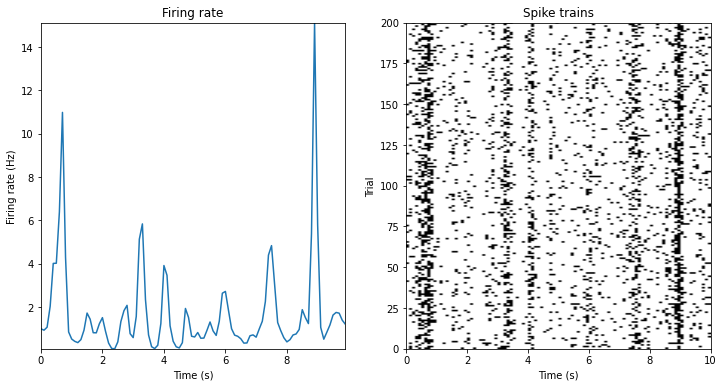

In [6]:
# c) Plot spike counts and predicted firing rate

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6))

ax1.plot(np.arange(0, stimulus_length*dt, dt), r_ts)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Firing rate (Hz)')
ax1.margins(0)
ax1.set_title('Firing rate')

ax2.imshow(y_ts, cmap='binary', aspect='auto', extent=[0,10,0,200])
ax2.set_ylabel('Trial')
ax2.set_xlabel('Time (s)')
ax2.set_title('Spike trains')

plt.show()

## 2) Estimating the underlying filter
The data above was generate from a single neuron. The neuron was given a stimulus as input and in produced a spike train, repeated for certain number of trials. 
The way the neuron processes the incoming stimulus into a spike train output can be characterized by its filter. Above we have generated this filter ourselves, now we want to rediscover it from data.

We will explore different approaches to estimate the underlying filter $\omega$: from data only, using an MLE, using the Laplace approximation.
But for all approaches we have to apply the filter to potentially a high number of trials, which can be computationally inefficient. 
Looking at the formulation of the Poisson GLM model we might recognize that the shifted multiplication of $\omega$ with the stimulus $x$ can be seen as convolution. 
Using this insight we can vectorize the application of the filter on the stimulus:

##### Hankel Matrix

The calculation of the convolution $\boldsymbol{\omega}*\vec{x}$ can be vectorized using the **Hankel** matrix:
\begin{equation*}
\mathbf{X} = \sum\limits_{t=k}^{T} \mathbf{x}_{t-k:t}
\end{equation*}
The Hankel matrix has shape `(num_trials * stimulus_length, k)` and contains the stimulus concatenated over all trials (rows), and shifted for every stimulus time lag $k$ (columns). 

Using the Hankel matrix the convolution can be written as follows (see also implementation below):
\begin{equation*}
z_{t} = \mathbf{X}\cdot \omega + b
\end{equation*}

### 2.1) The spike triggered average (STA)
The first approach is descriptive, i.e., we do not take into account our model but just estimate the filter from the observed spike trains. 
The idea of the spike triggered average (STA) is to estimate the filter by averaging over all stimuli that resulted in a spike. 

To calculate the STA you need to multiply the spike trains with the stimulus for every time lag.  
The Hankel matrix lets you do this in vectorized form:
\begin{equation*}
\text{STA} = \frac{\sum_{t=k}^{T} \mathbf{y}_t  \mathbf{x}_{t-k\text{ }:\text{ }t}}{\sum_{t=k}^{T} \mathbf{y}_t} = \frac{1}{\sum_{t}^{T} \mathbf{y}_t}\mathbf{y}\cdot \mathbf{X} 
\end{equation*}

(a) Generate the spike trains $\mathbf{y}$ using the given stimulus and filter (as above), but this time via the convolution between $\boldsymbol{\omega}$ and the stimulus. 
We provided a `convolution` function that you may use. (Hint: you need to generate $z$ with the `convolution` fun, then apply the non-linearity to get the rate, and then pass the rate to the Poisson process).

(b) Use the Hankel matrix (see function below) to calculate the STA. 

(c) Plot the results: Again plot the spike trains and the firing rate in separate subplots. In an additional subplot plot the true filter and the STA estimated filter on top of each other. Make sure to add labels, titles and legends where needed. 

In [7]:
def hankel(lags, _input):
    """Returns a Hankel matrix of size _input.size x lags
    Parameters:
    lags : int value. Number of input timebins in the past on which the response depends.
    _input : vector of float values. Input sequence to be converted in to a Hankel matrix.
    
    Returns:
    hank : matrix of float values of size '_input.size x lags'
    """
    hankel_collect = np.zeros((0,lags))
    for inp in _input:
        hank = np.zeros((len(inp), lags))
        hank[:, 0] = inp
        for lag in range(1, lags):
            hank[lag:, lag] = inp[:-lag]
        hankel_collect = np.concatenate((hankel_collect,hank),0)
    return hankel_collect


def convolution(_filter, _input):
    """Returns the convolution product of the inputs.
    Parameters:
    _filter : vector of float values containing the convolutional filter.
    _input : int value. The input to be convolved with the filter.
    
    Returns:
    Vector of float values, of same shape as '_input'.
    """
    hank = hankel(len(_filter), _input)
    return np.dot(hank, _filter).reshape(_input.shape)



In [8]:
# (a) Your code goes here

# Calculate firing rate using convolution (via Hankel matrix)
#print(np.arange(1,16).reshape(5,3))
#print(hankel(3, np.arange(1,16).reshape(5,3)))
conv = convolution(_filter, stimulus)

# Simulate from model
r_ts = np.exp(conv)
y_ts = np.random.poisson(lam=r_ts*dt, size=None).clip(0,1)
print(y_ts.shape)

(200, 100)


In [9]:
# (b) Your code goes here...

# Calculate STA via the Hankel matrix 

X = hankel(k, stimulus)
STA = 1 / y_ts.sum().sum() * (y_ts.flatten() @ X)
# disclaimer: in the instructions above the sum starts at k but this makes no sense here because the Hankel function 
# is implemented in a way that returns sequences also for the first k parts (zero-padded), so I sum over all of y_ts

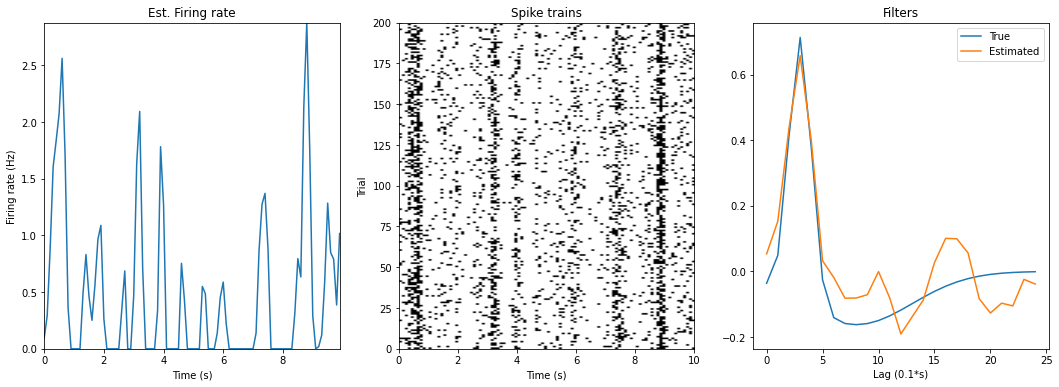

In [10]:
# (c) Plot spike counts and predicted firing rate
est_firing_rate = (X @ STA).reshape(stimulus.shape).mean(axis=0).clip(0)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18,6))

ax1.plot(np.arange(0, stimulus_length*dt, dt), est_firing_rate)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Firing rate (Hz)')
ax1.margins(0)
ax1.set_title('Est. Firing rate')

ax2.imshow(y_ts, cmap='binary', aspect='auto', extent=[0,10,0,200])
ax2.set_ylabel('Trial')
ax2.set_xlabel('Time (s)')
ax2.set_title('Spike trains')

ax3.plot(_filter, label='True')
ax3.plot(STA, label='Estimated')
ax3.set_xlabel(f'Lag ({dt}*s)')
ax3.set_title('Filters')
ax3.legend()

plt.show()

### 2.2) Maximum Likelihood Estimate

Above we estimated the filter from data. But we might be able to obtain a better fit if we take into account our generative model of the data---the Poisson GLM. 
Let's see if we can learn the parameters of this model: We get the MLE of the filter $\boldsymbol{\omega}$ using numerical optimization (there is no closed form, see exercise sheet). 
Because we set up our model as a GLM, the likelihood is guaranteed to be concave so that there exist a single optimum. 
Using the results from the theory exercises:

(b) In the exericse sheet you obtained the Laplace  to obtain the posterior standard deviation.  

(a) Write a function to calculate the (negative) log likelihood, $p(\mathbf{x},\mathbf{y}|\mathbf{\omega},b)$. **HINT**: Certain common helper functions, e.g. the factorial, can be imported rather than implemented from scratch.

(b) Using `scipy.optimize.minimize` or otherwise, identify the MLE.

(c) Plot the result: show the true filter, the STA estimate and the MLE estimate on top of each. Add labels, legend, etc.

In [11]:
def summed_factorial(responses, log = True):
    """ sum up the factorial of  a vector or matrix 
        set logarithm flag
    """
    responses = np.array(responses)
    responses = responses.flatten()
    responses = factorial(responses)
    if log:
        responses = np.log(responses)
    return np.sum(responses)

In [12]:
# (a) Write down a Python function that takes as input the LNP parameters (filter and baseline),
# the groundtruth stimulus and the groundtruth responses, and returns the log likelihood of the model.

# Your code goes here:

def log_likelihood(params, stimulus, responses, dt = 1):
    """ log likelihood of the model    
    """
    w = params[:k]  # shape (25,)
    b = params[k]  # scalar
    X = stimulus  # I assume we get the hankel matrix as input (shape (20000,25))
    y = responses  # shape (20000,)
    r = np.exp(X@w+b)  # shape (20000,)
    
    LL_per_example = y * np.log(r*dt) - r*dt- np.log(factorial(y))  # shape (20000,)
    LL = LL_per_example.sum()
    return LL
    
    
def neg_log_likelihood(params, stimulus, responses, dt = 1):
    """ return negative log likelihood"""
    return -log_likelihood(params, stimulus, responses, dt)

In [13]:
# (b) Minimize your log likelihood to get the MLE.

NLL = lambda params: neg_log_likelihood(params, X, y_ts.flatten(), dt = dt)
result = minimize(NLL, x0=(np.zeros(k+1)))
w_MLE = result.x[:k]
b_MLE = result.x[k]

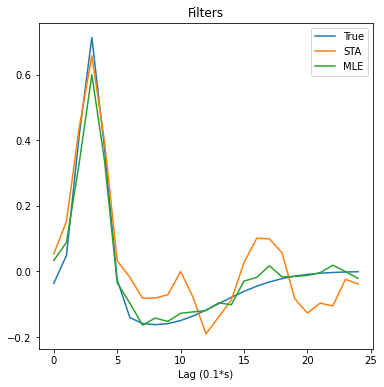

In [14]:
# (c) Plot the result
fig, ax3 = plt.subplots(1,1, figsize = (6,6))

ax3.plot(_filter, label='True')
ax3.plot(STA, label='STA')
ax3.plot(w_MLE, label='MLE')
ax3.set_xlabel(f'Lag ({dt}*s)')
ax3.set_title('Filters')
ax3.legend()

plt.show()

You should see that the MLE estimate is already much better in comparison to the STA estimate.

### 2.3) Maximum A-Posteriori Estimate

As in final part of the exercise sheet we now want to incorporate prior knowledge about the shape of the filter and perform Bayesian inference. 
Let us use the same prior as in the exercise sheet on the filter (standard normal). 
Like for the MLE, the MAP for the Poisson GLM we are using here is not available in analytical form, but it is concave, so we can get it with numerical optimization. 

(a) Write a function to calculate the (negative) log posterior, $p(\boldsymbol{\omega},b|\mathbf{x},\mathbf{y})$. **HINT**: log posterior = log prior + log likelihood

(b) Get the MAP by numerical optimization. 

(c) Use the Laplace approximation (see exercise sheet) and your results from the exercise sheet to write a function that returns the Hessian. Obtain the approximate posterior standard deviation around the MAP. 

(d) Plot the results: add a plot showing the true filter, the STA, the MLE and the MAP with error bars (marginal Laplace posterior standard deviation). Add labels, titles and legend. 

In [28]:
# (a) Write down a Python function that takes as input the LNP parameters (filter and baseline),
# the groundtruth stimulus and the groundtruth responses, and returns the log posterior of the model according
# to the Laplace approximation.

def log_posterior(params, stimulus, response, dt):
    """Returns log posterior of a linear-nonlinear Poisson model.
    Parameters:
    params : vector of floats containing parameters of model. Last element of vector should be the baseline offset.
    stimulus : vector / matrix of floats containing the input stimulus.
    response : vector / matrix of floats containing the responses of the neuron to the stimulus. Should be of same shape as the stimulus.
    dt : float value containing size of timebins in s.
    
    Returns:
    log_posterior : float value.
    """
    norm = 1/np.sqrt((2*np.pi)**(k+1))
    mean = np.zeros(k+1)
    log_prior = np.log(norm) - .5 * ((params-mean).T @ (params-mean))
    
    return log_prior + log_likelihood(params, stimulus, response, dt)

def nlogpost(params, stimulus, response, dt):
    """Returns negative log posterior of a linear-nonlinear Poisson model.
    Parameters:
    params : vector of floats containing parameters of model. Last element of vector should be the baseline offset.
    stimulus : vector / matrix of floats containing the input stimulus.
    response : vector / matrix of floats containing the responses of the neuron to the stimulus. Should be of same shape as the stimulus.
    dt : float value containing size of timebins in s.
    
    Returns:
    negative log posterior : float value
    """
    return -log_posterior(params, stimulus, response, dt)



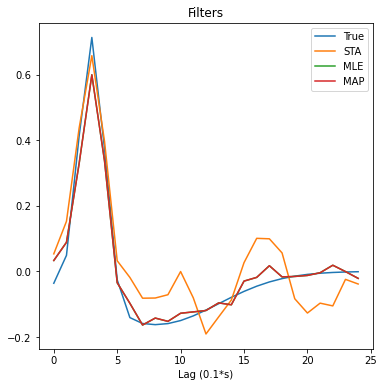

In [29]:
# (b) Find and plot the MAP

NLP = lambda params: nlogpost(params, X, y_ts.flatten(), dt = dt)
result = minimize(NLP, x0=(np.zeros(k+1)))
MAP_params = result.x
w_MAP = MAP_params[:k]
b_MAP = MAP_params[k]

fig, ax4 = plt.subplots(1,1, figsize = (6,6))

ax4.plot(_filter, label='True')
ax4.plot(STA, label='STA')
ax4.plot(w_MLE, label='MLE')
ax4.plot(w_MAP, label='MAP')
ax4.set_xlabel(f'Lag ({dt}*s)')
ax4.set_title('Filters')
ax4.legend()

plt.show()

In [46]:
# (c) Write down a Python function that takes as input the LNP parameters (filter and baseline),
# the groundtruth stimulus and the groundtruth responses, and returns the Hessian matrix of 
# the true posterior distribution of the filter and baseline parameter.

def hessian(params, stimulus, response, dt):
    """Returns the inverse of the Hessian of the log posterior of a linear nonlinear Poisson model, assuming a multivariate Gaussian prior with identity covariance matrix.
    Parameters:
    params : vector of floats containing parameters of model. Last element of vector should be the baseline offset.
    stimulus : vector / matrix of floats containing the input stimulus.
    response : vector / matrix of floats containing the responses of the neuron to the stimulus. Should be of same shape as the stimulus.
    dt : float value containing size of timebins in s.
    
    Returns:
    H_filter : matrix of size K x K, where K is the length of the convolutional filter.
    """
    w = params[:k]  # shape (25,)
    b = params[k]  # scalar
    X = stimulus  # I assume we get the hankel matrix as input (shape (20000,25))
    y = response  # shape (20000,)
    r = np.exp(X@w+b)  # shape (20000,)
    M = np.array([r_t *X_t.reshape(-1,1) @ X_t.reshape(1,-1) for X_t, r_t in zip(X, r)]).sum(axis=0)
    return -dt * M - np.identity(k)  # there are conflicting instructions on whether we should invert here or not, so we do it later


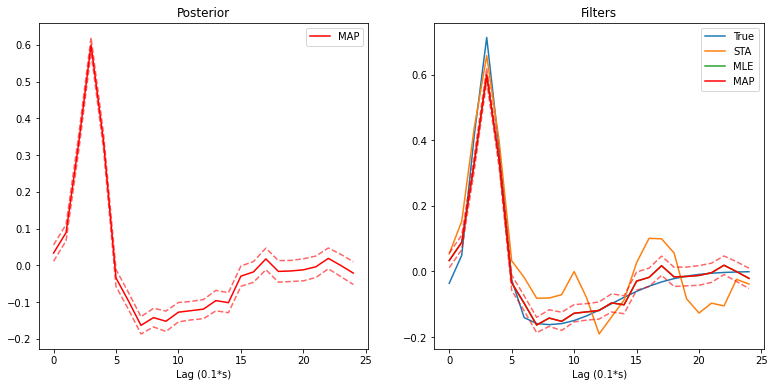

In [47]:
# (d) Plot the MAP estimate for the filter along with confidence intervals.

cov = -np.linalg.inv(hessian(MAP_params, X, y_ts.flatten(), dt=dt))
stds = np.sqrt(np.diag(cov))

fig, axs = plt.subplots(1,2, figsize = (13,6))

axs[1].plot(_filter, label='True')
axs[1].plot(STA, label='STA')
axs[1].plot(w_MLE, label='MLE')

for ax in axs:
    ax.plot(w_MAP, label='MAP', color='red')
    ax.plot(w_MAP + stds, linestyle='--', color='red', alpha=.6)
    ax.plot(w_MAP - stds, linestyle='--', color='red', alpha=.6)
    ax.set_xlabel(f'Lag ({dt}*s)')
    ax.legend()
    
    
axs[1].set_title('Filters')
axs[0].set_title('Posterior')

plt.show()

You should see that the MAP estimate lies close to the MLE estimate, but that it additionally provides error bars that represent the marginal standard deviation of the posterior, approximated with a Laplace approximation. 
This provides with uncertainty estimates on the filter weights. 

Overall, we can use this approach to investigate the properties of individual neurons, by estimating their stimulus filter. 